In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
from context import pypho
import matplotlib.pyplot as plt

# Moharam, Grann, Pommet, & Gaylord: Fig. 2

## Run simulation

In [3]:
%%time

wavelength = 1
lattice_constant = 1
theta = np.pi/18
phi = 0
#psi = np.pi/4
order = 0

frequency = 2*np.pi/wavelength

n = 2.04

d_num = 100
d_range = np.linspace(0, 5, d_num)/n

num_order = 50

r_tm = np.zeros(d_num)
r_te = np.zeros(d_num)

# Create simulation object
momentum = frequency*np.array([np.sin(theta)*np.cos(phi),
                               np.sin(theta)*np.sin(phi)])
sim = pypho.simulation_1d.new(frequency, momentum, num_order)

# Initialize stack
sim.stack.set_lattice_constant(lattice_constant)

# Define materials
sim.stack.define_material('vacuum', 1)
sim.stack.define_material('SiO2', n**2)

# Define patterns
sim.stack.define_pattern('vacuum', 'vacuum')
sim.stack.define_pattern('grating', ['SiO2', 'vacuum'], [.5, .5])
sim.stack.define_pattern('substrate', 'SiO2')

# Define stack
sim.stack.add_layers(['vacuum', 'grating', 'substrate'],
                     [None, 1., None])


for i, d in enumerate(d_range):
    sim.stack.set_layer_thickness(1, d)

    sim.run()

    r_tm[i] = np.abs(sim.get_reflection(polarization_in=[0,1], polarization_out=[0,1], order_out=order))**2
    r_te[i] = np.abs(sim.get_reflection(polarization_in=[1,0], polarization_out=[1,0], order_out=order))**2


CPU times: user 1.78 s, sys: 7.87 ms, total: 1.79 s
Wall time: 913 ms


## Run S4

In [4]:
import os
os.system('S4 lua/moharam_fig2.lua > lua/moharam_fig2.csv');

data = np.loadtxt('lua/moharam_fig2.csv', delimiter=',')
r_te_s4 = data[:,0]
r_tm_s4 = data[:,1]

## Plot

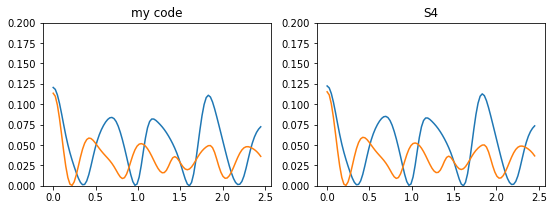

In [5]:
plt.figure(1, figsize=(9, 3))

plt.subplot(121)
plt.plot(d_range, r_te);
plt.plot(d_range, r_tm);
plt.ylim(0, .2);
plt.title('my code')

plt.subplot(122)
plt.plot(d_range, r_te_s4);
plt.plot(d_range, r_tm_s4);
plt.ylim(0, .2);
plt.title('S4')

plt.show()

In [6]:
wavelength = 1
lattice_constant = 1.1
phi = 0
theta_range = np.linspace(0, np.pi/2, 100)

frequency = 2*np.pi/wavelength

n1 = 1.01
n2 = 2.04

num_order = 1

# Create simulation object
sim = pypho.simulation_1d.new(frequency, (0,0), num_order)

# Initialize stack
sim.stack.set_lattice_constant(lattice_constant)

# Define materials
sim.stack.define_material('n1', n1**2)
sim.stack.define_material('n2', n2**2)

# Define patterns
sim.stack.define_pattern('n1', 'n1')
sim.stack.define_pattern('n2', 'n2')

sim.stack.add_layers(['n1', 'n2'],
                     [None, None])

rs = np.zeros(len(theta_range), dtype=np.cdouble)
rp = np.zeros(len(theta_range), dtype=np.cdouble)
for i, theta in enumerate(theta_range):
    momentum = n1*frequency*np.array([np.sin(theta)*np.cos(phi),
                               np.sin(theta)*np.sin(phi)])
    sim.set_momentum(momentum)
    sim.run()
    rp[i] = sim.get_reflection(polarization_in=[0,1], polarization_out=[0,1])
    rs[i] = sim.get_reflection(polarization_in=[1,0], polarization_out=[1,0])

ct = np.sqrt(1 - n1**2/n2**2*np.sin(theta_range)**2)
rs_theory = (n1*np.cos(theta_range) - n2*ct)/(n1*np.cos(theta_range) + n2*ct)
rp_theory = (n2*np.cos(theta_range) - n1*ct)/(n2*np.cos(theta_range) + n1*ct)

# things are nasty when theta=pi/2 and n1=1
# careful about specifying input momentum

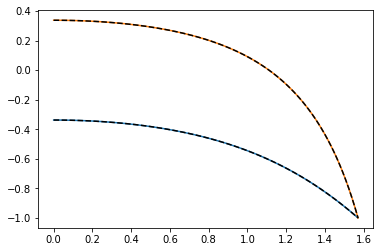

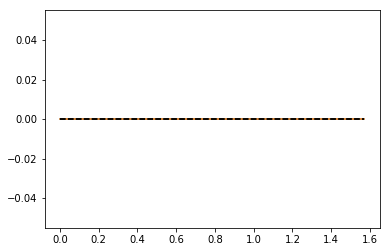

In [7]:
plt.figure()
plt.plot(theta_range, np.real(rs));
plt.plot(theta_range, -np.real(rp));
plt.plot(theta_range, np.real(rs_theory), 'k--');
plt.plot(theta_range, np.real(rp_theory), 'k--');

plt.figure()
plt.plot(theta_range, np.imag(rs));
plt.plot(theta_range, -np.imag(rp));
plt.plot(theta_range, np.imag(rs_theory), 'k--');
plt.plot(theta_range, np.imag(rp_theory), 'k--');